In [1]:
# GPU selection
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import csv
texts, labels = [], []
with open('data.csv', encoding='utf-8') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        headline = str(row[1])
        try:
            labels.append(int(row[2]))
            texts.append(headline)
        except:
            pass

In [3]:
print(round(len(texts)/1e6, 3), "million examples")
print("example:", texts[0], "with label", labels[0])

5.773 million examples
example: saffron slams naveen for votebank politics with label 0


In [4]:
import numpy as np
import pandas as pd
import re, sys, os, csv, keras, pickle
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model
print("[+] Using Keras version",keras.__version__)

Using TensorFlow backend.


[+] Using Keras version 2.2.2


In [5]:
"""
tokenizer = Tokenizer(num_words=2e6)
tokenizer.fit_on_texts(texts)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("[i] Saved word tokenizer to file: tokenizer.pickle")
"""

'\ntokenizer = Tokenizer(num_words=2e6)\ntokenizer.fit_on_texts(texts)\nwith open(\'tokenizer.pickle\', \'wb\') as handle:\n    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)\nprint("[i] Saved word tokenizer to file: tokenizer.pickle")\n'

In [6]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

word_index = tokenizer.word_index
print('[i] Found %s unique tokens.' % len(word_index))

[i] Found 638727 unique tokens.


In [7]:
MAX_SEQUENCE_LENGTH = 20
VALIDATION_SPLIT = 0.3
EMBEDDING_DIM = 100
GLOVE_DIR = "../glove/glove.6B/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [8]:
sequences = tokenizer.texts_to_sequences(texts)

data = pad_sequences(sequences, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
labels = to_categorical(np.asarray(labels))
print('[+] Shape of data tensor:', data.shape)
print('[+] Shape of label tensor:', labels.shape)

[+] Shape of data tensor: (5772866, 20)
[+] Shape of label tensor: (5772866, 2)


In [9]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('[i] Number of entries in each category:')
print("[+] Training:\n",y_train.sum(axis=0))
print("[+] Validation:\n",y_val.sum(axis=0))

[i] Number of entries in each category:
[+] Training:
 [1872594. 2168413.]
[+] Validation:
 [801417. 930442.]


In [10]:
embeddings_index = {}
f = open(GLOVE_DIR)
print("[i] Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

[i] Loading GloVe from: ../glove/glove.6B/glove.6B.100d.txt ...

In [11]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [13]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

In [14]:
l_conv_3 = Conv1D(filters=256,kernel_size=3,activation='relu')(embedded_sequences)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=256,kernel_size=5,activation='relu')(embedded_sequences)
l_conv_5 = Dropout(0.3)(l_conv_5)

l_conv_7 = Conv1D(filters=256,kernel_size=7,activation='relu')(embedded_sequences)
l_conv_7 = Dropout(0.3)(l_conv_7)

l_conv = Concatenate(axis=1)([l_conv_3, l_conv_5, l_conv_7])

In [15]:
l_pool = MaxPooling1D(2)(l_conv)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(32, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

In [16]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=1.2, rho=0.95, epsilon=None, decay=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [17]:
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 100)      63872800    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 18, 256)      77056       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 16, 256)      128256      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [20]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=512)

model.save("clickbait.h5")

Train on 4041007 samples, validate on 1731859 samples
Epoch 1/20
4041007/4041007 [==============================] - 233s 58us/step - loss: 0.3703 - acc: 0.8379 - val_loss: 0.3512 - val_acc: 0.8484
Epoch 2/20
4041007/4041007 [==============================] - 232s 57us/step - loss: 0.3563 - acc: 0.8449 - val_loss: 0.3443 - val_acc: 0.8520
Epoch 3/20
4041007/4041007 [==============================] - 231s 57us/step - loss: 0.3515 - acc: 0.8473 - val_loss: 0.3407 - val_acc: 0.8537
Epoch 4/20
4041007/4041007 [==============================] - 232s 57us/step - loss: 0.3486 - acc: 0.8488 - val_loss: 0.3383 - val_acc: 0.8550
Epoch 5/20
4041007/4041007 [==============================] - 231s 57us/step - loss: 0.3465 - acc: 0.8498 - val_loss: 0.3365 - val_acc: 0.8559
Epoch 6/20
4041007/4041007 [==============================] - 232s 57us/step - loss: 0.3448 - acc: 0.8507 - val_loss: 0.3349 - val_acc: 0.8567
Epoch 7/20
4041007/4041007 [==============================] - 232s 57us/step - loss: 0.3

KeyboardInterrupt: 

In [21]:
model.save("clickbait.h5")

In [22]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle
classes = ["not_clickbait", "clickbait"]
model_test = model

In [23]:
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

print(classification_report(Y_test, y_pred_class, target_names=classes))

               precision    recall  f1-score   support

not_clickbait       0.87      0.82      0.84    801417
    clickbait       0.85      0.89      0.87    930442

  avg / total       0.86      0.86      0.86   1731859



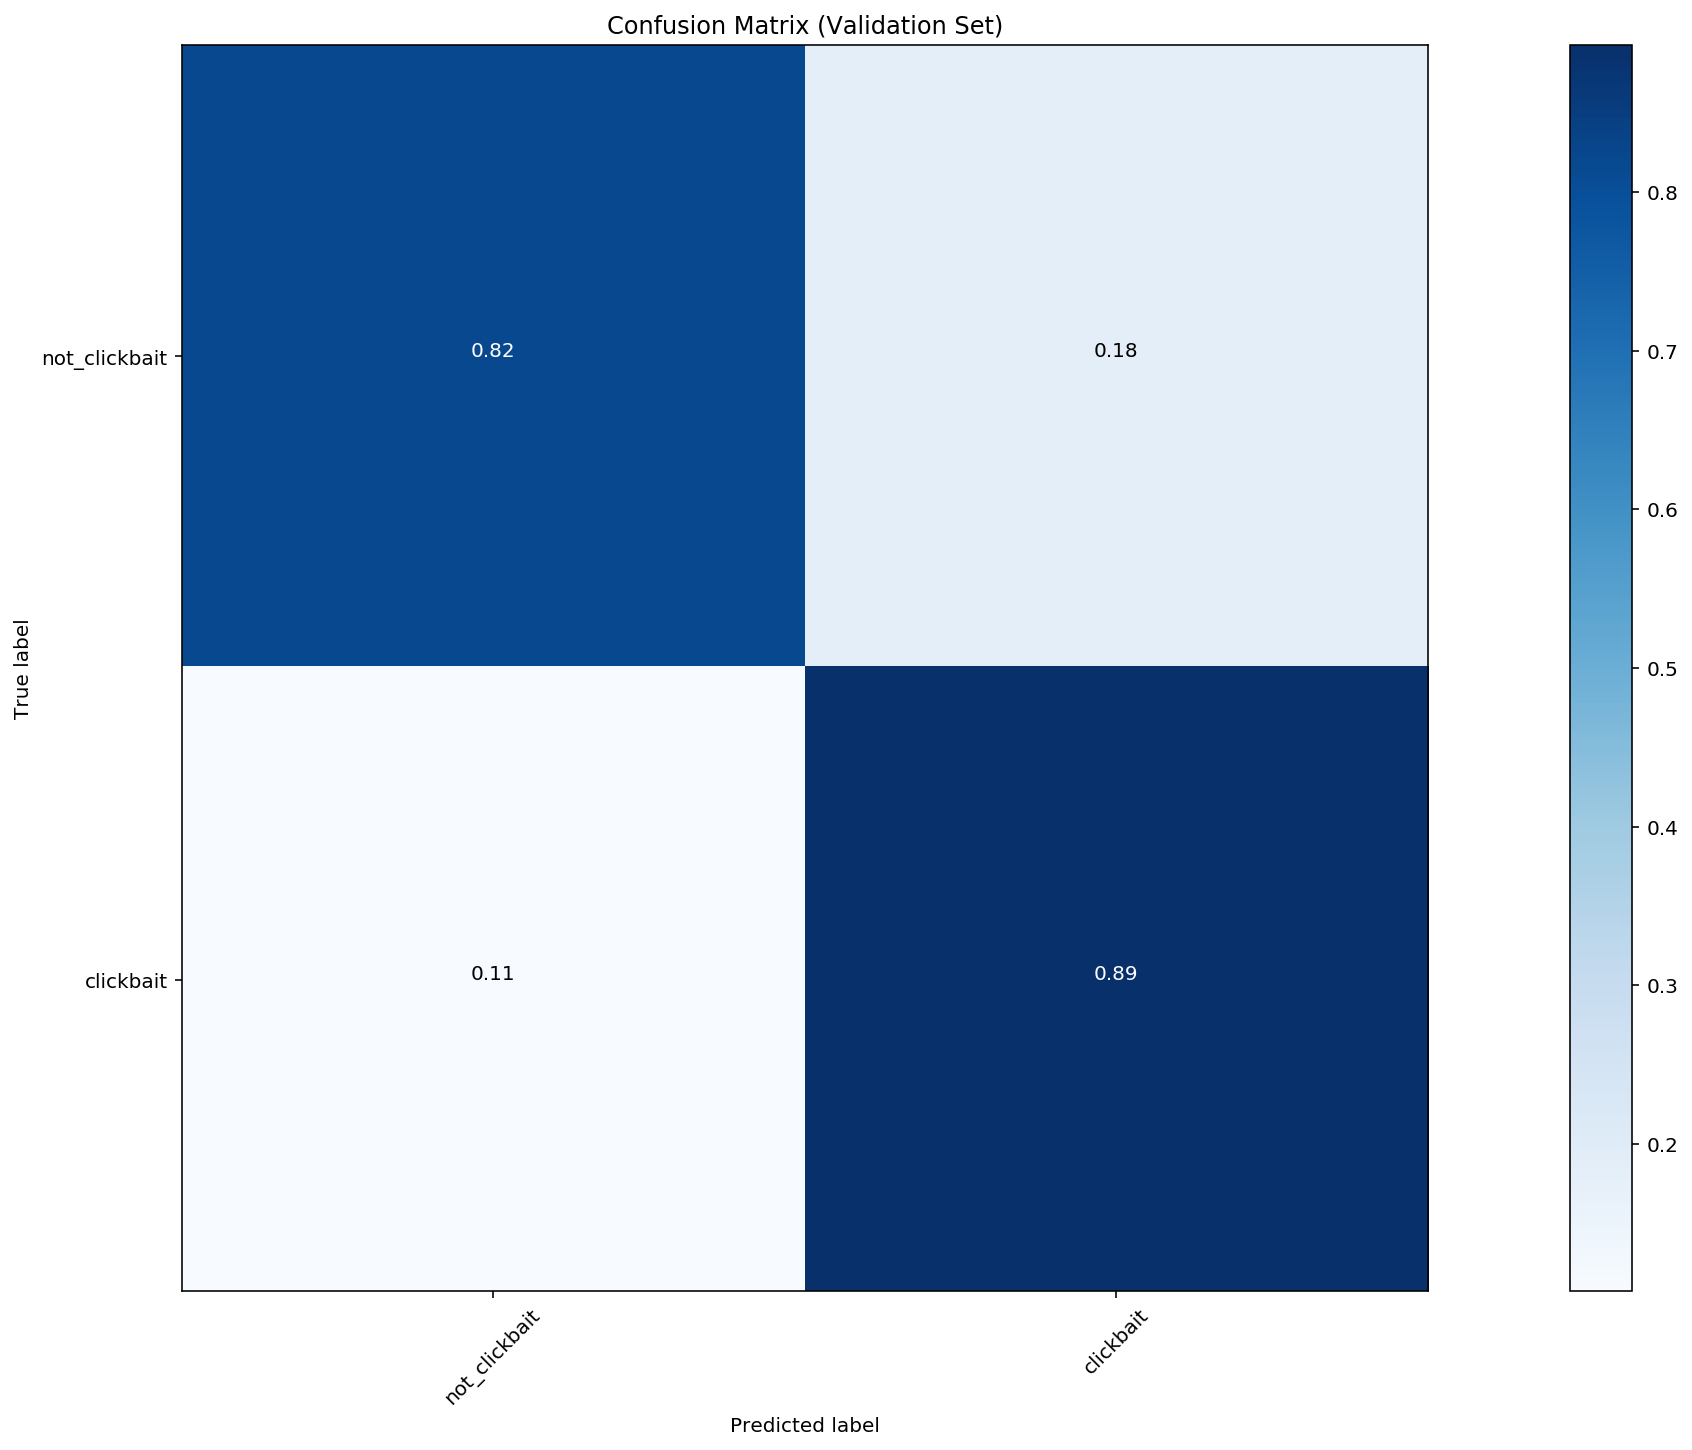

In [24]:
def plot_confusion_matrix(cm, labels, normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

In [25]:
text = ["Age discrimination taking root in Singapore Football?",
        "NSF & HIS GF TURN THE TABLES ON ENTITLED AUNTIE WHO DEMANDED FOR MRT SEAT",
        "Employment shrank, but Straits Times says job prospects improving?",
        "How many 'billions' has HDB made from housing sales?",
        "How much profits in total are made from providing electricity to Singaporeans? $1.6b a year?",
        "Growth At Any Cost: Top Facebook Executive Defended Data Collection In 2016 Memo and Warned That Facebook Could Get People Killed",
        "42 Reasons Why Studying Abroad In Singapore Ruins You For Life"]

In [26]:
for txt in text:
    txt = re.sub(r'[^\w\s]','', txt.lower())

sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model_test.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

Age discrimination taking root in Singapore Football? 
Prediction: not_clickbait 

NSF & HIS GF TURN THE TABLES ON ENTITLED AUNTIE WHO DEMANDED FOR MRT SEAT 
Prediction: clickbait 

Employment shrank, but Straits Times says job prospects improving? 
Prediction: not_clickbait 

How many 'billions' has HDB made from housing sales? 
Prediction: not_clickbait 

How much profits in total are made from providing electricity to Singaporeans? $1.6b a year? 
Prediction: not_clickbait 

Growth At Any Cost: Top Facebook Executive Defended Data Collection In 2016 Memo and Warned That Facebook Could Get People Killed 
Prediction: clickbait 

42 Reasons Why Studying Abroad In Singapore Ruins You For Life 
Prediction: not_clickbait 

